<a href="https://colab.research.google.com/github/Lord0fTheFlies/NMA-DL-Project/blob/main/symptoms_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Neural Network 1

#Imports

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import numpy as np

In [ ]:
df = pd.read_csv('/content/LLM_df_stringify_filtered.csv')
num_rows, num_columns = df.shape
print(f'Number of rows: {num_rows}')
print(f'Number of columns: {num_columns}')


Number of rows: 26350
Number of columns: 3


In [ ]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26350 entries, 0 to 26349
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      26350 non-null  int64 
 1   diseases        26350 non-null  object
 2   Symptom_labels  26350 non-null  object
dtypes: int64(1), object(2)
memory usage: 617.7+ KB
None


In [ ]:
df.sample(n=5)

,Unnamed: 0,diseases,Symptom_labels
6788,6788,diabetic ketoacidosis,"depressive or psychotic symptoms, sharp abdomi..."
24871,24871,transient ischemic attack,"depressive or psychotic symptoms, dizziness, w..."
22758,22758,spina bifida,"headache, skin lesion, eye moves abnormally, d..."
19969,19969,presbyopia,"pain in eye, abnormal movement of eyelid, fore..."
7107,7107,diverticulitis,"blood in stool, vomiting, lower abdominal pain..."


In [ ]:
print(len(df['diseases'].unique()))

527


In [ ]:
df['diseases'].value_counts()

diseases
abdominal aortic aneurysm    50
paronychia                   50
parasitic disease            50
panic disorder               50
panic attack                 50
                             ..
esophageal cancer            50
erectile dysfunction         50
epilepsy                     50
epididymitis                 50
yeast infection              50
Name: count, Length: 527, dtype: int64

In [ ]:
from pickle import TRUE

# Find duplicate symptoms with different disease names
duplicates = df[df.duplicated(subset=['Symptom_labels'], keep=False)]
duplicate_counts = duplicates.groupby('Symptom_labels')['diseases'].nunique()
conflicting_symptoms = duplicate_counts[duplicate_counts > 1].index

# Print the count of such cases
print(f'Count of duplicate symptoms with different diseases: {len(conflicting_symptoms)}')

# Print examples
print(duplicates[duplicates['Symptom_labels'].isin(conflicting_symptoms)].head())

# Remove all rows with conflicting symptoms and keep the first occurrence
df_cleaned = df.drop_duplicates(subset=['Symptom_labels'], keep='first')

# Print the updated dataframe
print(df_cleaned.info())


Count of duplicate symptoms with different diseases: 471
     Unnamed: 0                   diseases  \
38           38  abdominal aortic aneurysm   
118         118            abscess of nose   
122         122            abscess of nose   
163         163     abscess of the pharynx   
174         174     abscess of the pharynx   

                                     Symptom_labels  
38                shortness of breath, palpitations  
118               nasal congestion, vomiting, fever  
122                      sore throat, fever, coryza  
163                          cough, headache, fever  
174  sharp chest pain, sore throat, cough, headache  
<class 'pandas.core.frame.DataFrame'>
Index: 21378 entries, 0 to 26348
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      21378 non-null  int64 
 1   diseases        21378 non-null  object
 2   Symptom_labels  21378 non-null  object
dtypes: int64(1), o

In [ ]:
print(len(df_cleaned['diseases'].unique()))
df_cleaned['diseases'].value_counts()

527


diseases
injury to the arm                     50
conductive hearing loss               50
oral thrush (yeast infection)         50
diverticulitis                        50
otitis externa (swimmer's ear)        50
                                      ..
fracture of the skull                 12
injury to the abdomen                 11
hormone disorder                      10
idiopathic infrequent menstruation     8
salivary gland disorder                8
Name: count, Length: 527, dtype: int64

In [ ]:
# Remove the 'Unnamed: 0' column
df_cleaned = df_cleaned.loc[:, ~df_cleaned.columns.str.contains('^Unnamed')]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

# Encode the symptoms using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_cleaned['Symptom_labels']).toarray()

# Encode the diseases
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_cleaned['diseases'])

# Split the data into training and test sets
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_v1)
X_test_scaled = scaler.transform(X_test_v1)

# Convert to PyTorch tensors
X_train_tensor_v1 = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor_v1 = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor_v1 = torch.tensor(y_train_v1, dtype=torch.long)
y_test_tensor_v1 = torch.tensor(y_test_v1, dtype=torch.long)

In [ ]:
# Define your neural network model
class EnhancedNeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EnhancedNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, output_dim)
        self.output_dim = output_dim

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        if self.output_dim > 1:
            x = nn.functional.log_softmax(self.fc4(x), dim=1)
        else:
            x = torch.sigmoid(self.fc4(x))
        return x


In [ ]:
import matplotlib.pyplot as plt

# Function to train the model and track accuracy
def train_model_v1(model, X_train, y_train, X_test, y_test, optimizer, criterion, num_epochs=50, batch_size=64):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    model.train()
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accs.append(train_accuracy)

        # Evaluate on test set
        model.eval()
        correct_test = 0
        total_test = 0
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(test_loss)
        test_accuracy = 100 * correct_test / total_test
        test_accs.append(test_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    # Plotting
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accs, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/50, Loss: 2.9246, Train Accuracy: 45.05%, Test Accuracy: 73.67%
Epoch 2/50, Loss: 0.7705, Train Accuracy: 76.90%, Test Accuracy: 77.85%
Epoch 3/50, Loss: 0.5808, Train Accuracy: 81.87%, Test Accuracy: 79.44%
Epoch 4/50, Loss: 0.4824, Train Accuracy: 84.72%, Test Accuracy: 80.73%
Epoch 5/50, Loss: 0.4277, Train Accuracy: 86.02%, Test Accuracy: 81.20%
Epoch 6/50, Loss: 0.3882, Train Accuracy: 87.57%, Test Accuracy: 80.68%
Epoch 7/50, Loss: 0.3237, Train Accuracy: 89.67%, Test Accuracy: 80.17%
Epoch 8/50, Loss: 0.3136, Train Accuracy: 90.01%, Test Accuracy: 81.62%
Epoch 9/50, Loss: 0.2676, Train Accuracy: 91.40%, Test Accuracy: 80.61%
Epoch 10/50, Loss: 0.2462, Train Accuracy: 92.02%, Test Accuracy: 81.34%
Epoch 11/50, Loss: 0.2303, Train Accuracy: 92.51%, Test Accuracy: 80.80%
Epoch 12/50, Loss: 0.2477, Train Accuracy: 92.51%, Test Accuracy: 81.13%
Epoch 13/50, Loss: 0.2117, Train Accuracy: 93.38%, Test Accuracy: 80.43%
Epoch 14/50, Loss: 0.1968, Train Accuracy: 94.02%, Test Accu

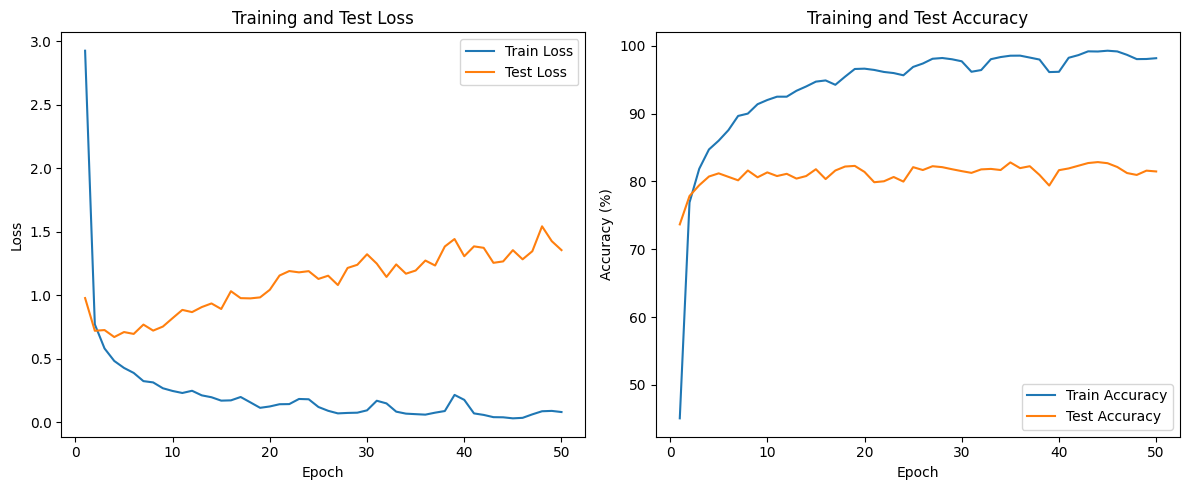

In [ ]:
# Initialize model and optimizer
model_v1 = EnhancedNeuralNet(X_train_tensor_v1.shape[1], len(label_encoder.classes_))
optimizer_v1 = optim.Adam(model_v1.parameters(), lr=0.001)
criterion_v1 = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification

# Train the model
train_model_v1(model_v1, X_train_tensor_v1, y_train_tensor_v1, X_test_tensor_v1, y_test_tensor_v1, optimizer_v1, criterion_v1)


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Function to evaluate the model
def evaluate_model_v1(model, criterion, X_test_tensor, y_test_tensor):
    model.eval()
    test_loss = 0.0
    y_true = []
    y_pred = []

    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)

        # Calculate accuracy
        accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()) * 100

        # Calculate loss (if needed)
        loss = criterion(outputs, y_test_tensor)
        test_loss = loss.item()

        # Convert tensors to numpy arrays for metrics calculation
        y_true = y_test_tensor.cpu().numpy()
        y_pred = predicted.cpu().numpy()

    # Calculate precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

# Evaluate the model
evaluate_model_v1(model_v1, criterion_v1, X_test_tensor_v1, y_test_tensor_v1)


Test Accuracy: 81.48%
Test Loss: 1.3550
Precision: 0.8444
Recall: 0.8148
F1 Score: 0.8170


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Enhanced model**

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 3.5683, Train Accuracy: 33.62%, Val Loss: 1.3915, Val Accuracy: 72.84%
Epoch 2/50, Train Loss: 1.2304, Train Accuracy: 70.09%, Val Loss: 0.6980, Val Accuracy: 82.84%
Epoch 3/50, Train Loss: 0.8625, Train Accuracy: 76.08%, Val Loss: 0.5630, Val Accuracy: 83.86%
Epoch 4/50, Train Loss: 0.7223, Train Accuracy: 79.44%, Val Loss: 0.5111, Val Accuracy: 84.42%
Epoch 5/50, Train Loss: 0.6572, Train Accuracy: 80.59%, Val Loss: 0.4719, Val Accuracy: 85.44%
Epoch 6/50, Train Loss: 0.6092, Train Accuracy: 81.55%, Val Loss: 0.4519, Val Accuracy: 85.85%
Epoch 7/50, Train Loss: 0.5821, Train Accuracy: 82.44%, Val Loss: 0.4549, Val Accuracy: 85.12%
Epoch 8/50, Train Loss: 0.5578, Train Accuracy: 82.60%, Val Loss: 0.4464, Val Accuracy: 85.59%
Epoch 9/50, Train Loss: 0.5087, Train Accuracy: 84.26%, Val Loss: 0.4420, Val Accuracy: 85.97%
Epoch 10/50, Train Loss: 0.5018, Train Accuracy: 84.18%, Val Loss: 0.4425, Val Accuracy: 85.79%
Epoch 11/50, Train Loss: 0.4796, Train Accuracy: 

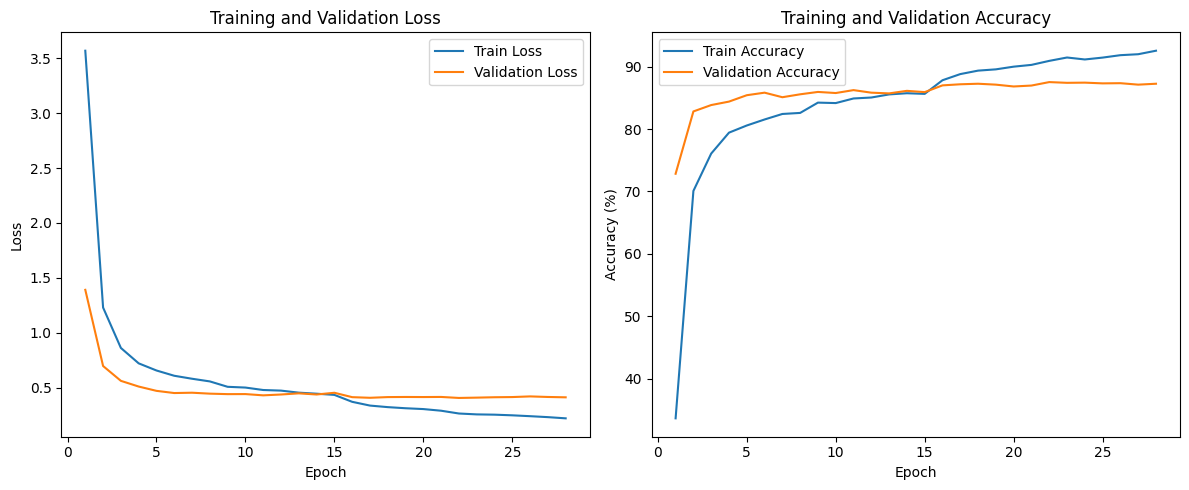

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Split dataset into train, validation, and test sets
X_train_enhanced, X_test_enhanced, y_train_enhanced, y_test_enhanced = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_enhanced, X_val_enhanced, y_train_enhanced, y_val_enhanced = train_test_split(X_train_enhanced, y_train_enhanced, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
def convert_to_tensor(data):
    return torch.tensor(data, dtype=torch.float32)

X_train_tensor = convert_to_tensor(X_train_enhanced)
X_val_tensor = convert_to_tensor(X_val_enhanced)
X_test_tensor = convert_to_tensor(X_test_enhanced)
y_train_tensor = torch.tensor(y_train_enhanced, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_enhanced, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_enhanced, dtype=torch.long)

# Define a slightly more complex neural network model
class SimpleNeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, output_dim)
        self.output_dim = output_dim

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.log_softmax(self.fc3(x), dim=1)  # Assuming multi-class classification
        return x

# Function to train the model and track accuracy
def train_model_enhanced(model, X_train, y_train, X_val, y_val, optimizer, criterion, scheduler=None, num_epochs=50, batch_size=64):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    patience = 5  # Adjust as needed

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accs.append(train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct_val / total_val
        val_accs.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # Adjust learning rate if scheduler is provided
        if scheduler is not None:
            scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement > patience:
            print(f'Early stopping at epoch {epoch+1}, best validation loss: {best_val_loss:.4f}')
            break

    # Plotting
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
    plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Initialize model, optimizer, and loss function
input_dim_enhanced = X_train_enhanced.shape[1]  # Assuming input dimensions
output_dim_enhanced = len(set(y_train_enhanced))  # Assuming output dimensions for classification
model_enhanced = SimpleNeuralNet(input_dim_enhanced, output_dim_enhanced)
optimizer_enhanced = torch.optim.Adam(model_enhanced.parameters(), lr=0.001)
scheduler_enhanced = ReduceLROnPlateau(optimizer_enhanced, mode='min', factor=0.5, patience=3, verbose=True)
criterion_enhanced = nn.CrossEntropyLoss()

# Train the model
train_model_enhanced(model_enhanced, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, optimizer_enhanced, criterion_enhanced, scheduler=scheduler_enhanced, num_epochs=50, batch_size=64)



In [ ]:
# Evaluate the model on the test set
def evaluate_model_enhanced(model, X_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()) * 100
        precision, recall, f1, _ = precision_recall_fscore_support(y_test_tensor.cpu().numpy(), predicted.cpu().numpy(), average='weighted')
        print(f'Test Accuracy: {accuracy:.2f}%')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')

# Convert test data to PyTorch tensor
evaluate_model_enhanced(model_enhanced, X_test_tensor, y_test_tensor)

Test Accuracy: 86.86%
Precision: 0.8879
Recall: 0.8686
F1 Score: 0.8697


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Function to evaluate the model
def evaluate_model(model, criterion, X_test_tensor, y_test_tensor):
    model.eval()
    test_loss = 0.0
    y_true = []
    y_pred = []

    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)

        # Calculate accuracy
        accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()) * 100

        # Calculate loss (if needed)
        loss = criterion(outputs, y_test_tensor)
        test_loss = loss.item()

        # Convert tensors to numpy arrays for metrics calculation
        y_true = y_test_tensor.cpu().numpy()
        y_pred = predicted.cpu().numpy()

    # Calculate precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

# Evaluate the model
print('Version 1 Model:')
evaluate_model(model_v1, criterion_v1, X_test_tensor_v1, y_test_tensor_v1)
print('Enhanced Model:')
evaluate_model(model_enhanced, criterion_enhanced, X_test_tensor, y_test_tensor)


Version 1 Model:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 81.48%
Test Loss: 1.3550
Precision: 0.8444
Recall: 0.8148
F1 Score: 0.8170
Enhanced Model:
Test Accuracy: 86.86%
Test Loss: 0.4391
Precision: 0.8879
Recall: 0.8686
F1 Score: 0.8697


In [ ]:
torch.save(model_v1.state_dict(), 'symptoms_disease_model_v1.pth')
torch.save(model_enhanced.state_dict(), 'symptoms_disease_model_enhanced.pth')

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, average_precision_score

# Function to evaluate the model
def evaluate_model(model, criterion, X_test_tensor, y_test_tensor):
    model.eval()
    test_loss = 0.0
    y_true = []
    y_pred = []

    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)

        # Calculate accuracy
        accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()) * 100

        # Calculate loss (if needed)
        loss = criterion(outputs, y_test_tensor)
        test_loss = loss.item()

        # Convert tensors to numpy arrays for metrics calculation
        y_true = y_test_tensor.cpu().numpy()
        y_pred = predicted.cpu().numpy()

    # Calculate precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    return accuracy, test_loss, precision, recall, f1

# Function to calculate AUPRC
def calculate_auprc(model, X_test_tensor, y_test_tensor):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        outputs = model(X_test_tensor)
        y_true = y_test_tensor.cpu().numpy()
        y_scores = outputs.cpu().numpy()

    # Calculate AUPRC for each class
    auprc_scores = []
    for i in range(y_scores.shape[1]):
        auprc = average_precision_score(y_true == i, y_scores[:, i])
        auprc_scores.append(auprc)

    # Average AUPRC over all classes
    mean_auprc = np.mean(auprc_scores)
    return mean_auprc

# Evaluate Version 1 Model
accuracy_v1, test_loss_v1, precision_v1, recall_v1, f1_v1 = evaluate_model(model_v1, criterion_v1, X_test_tensor_v1, y_test_tensor_v1)
mean_auprc_v1 = calculate_auprc(model_v1, X_test_tensor_v1, y_test_tensor_v1)

# Evaluate Enhanced Model
accuracy_enhanced, test_loss_enhanced, precision_enhanced, recall_enhanced, f1_enhanced = evaluate_model(model_enhanced, criterion_enhanced, X_test_tensor, y_test_tensor)
mean_auprc_enhanced = calculate_auprc(model_enhanced, X_test_tensor, y_test_tensor)

# Create DataFrame for comparison
comparison_data = {
    "Metric": ["Test Accuracy", "Test Loss", "Precision", "Recall", "F1 Score", "Mean AUPRC"],
    "Version 1 Model": [f"{accuracy_v1:.2f}%", f"{test_loss_v1:.4f}", f"{precision_v1:.4f}", f"{recall_v1:.4f}", f"{f1_v1:.4f}", f"{mean_auprc_v1:.4f}"],
    "Enhanced Model": [f"{accuracy_enhanced:.2f}%", f"{test_loss_enhanced:.4f}", f"{precision_enhanced:.4f}", f"{recall_enhanced:.4f}", f"{f1_enhanced:.4f}", f"{mean_auprc_enhanced:.4f}"]
}

comparison_df = pd.DataFrame(comparison_data)

# Display the table
print(comparison_df)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all threshold

          Metric Version 1 Model Enhanced Model
0  Test Accuracy          81.48%         86.86%
1      Test Loss          1.3550         0.4391
2      Precision          0.8444         0.8879
3         Recall          0.8148         0.8686
4       F1 Score          0.8170         0.8697
5     Mean AUPRC          0.8673         0.9288


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

def preprocess_symptoms(symptoms_text, vectorizer, scaler):
    symptoms_transformed = vectorizer.transform([symptoms_text]).toarray()
    symptoms_scaled = scaler.transform(symptoms_transformed)
    symptoms_tensor = torch.tensor(symptoms_scaled, dtype=torch.float32)
    return symptoms_tensor

def predict_diseases(symptoms_text, model, vectorizer, label_encoder, scaler):
    symptoms_tensor = preprocess_symptoms(symptoms_text, vectorizer, scaler)
    model.eval()

    with torch.no_grad():
        outputs = model(symptoms_tensor)
        probabilities = F.softmax(outputs, dim=1)

    predicted_index = torch.argmax(outputs).item()
    predicted_label = label_encoder.inverse_transform([predicted_index])[0]
    return predicted_label, probabilities.numpy()

input_symptoms_text = "sharp chest pain, sore throat, cough, headache"
predicted_label, probabilities = predict_diseases(input_symptoms_text, model_enhanced, vectorizer, label_encoder, scaler)

print("Predicted Disease:", predicted_label)


Predicted Disease: abscess of the pharynx
